# Object Detection and tracking in video
โค้ดนี้เป็นตัวอย่างของการใช้โมเดลในการตรวจจับวัตถุในวิดีโอ การติดตามวัตถุ และการวิเคราะห์ข้อมูลที่ได้จากการตรวจจับ ซึ่งสามารถนำไปประยุกต์ใช้ในงานด้านการวิเคราะห์วิดีโอ การตรวจสอบคุณภาพในสายการผลิต หรือการติดตามการเคลื่อนไหวของวัตถุในวิดีโอได้



## การติดตั้งและนำเข้าไลบรารี
ติดตั้ง ultralytics ซึ่งเป็นไลบรารีสำหรับ YOLO และนำเข้าไลบรารีที่จำเป็นอื่นๆ

In [ ]:
!pip install ultralytics --quiet
exit()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.4/881.4 kB 17.0 MB/s eta 0:00:00


### import

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Image
import plotly.express as px
import time
import math

## การเตรียมข้อมูลและโหลดโมเดล
ดาวน์โหลดไฟล์วิดีโอและโมเดล YOLO ที่ผ่านการเทรนมาแล้ว จากนั้นโหลดโมเดลเข้าสู่หน่วยความจำ

In [ ]:
# ดาวน์โหลดวิดีโอ
!gdown 1RfNxo4AFAdTuzkIRc5jtYzC_-HrugKFu  
# ดาวน์โหลดโมเดลที่ฝึกไว้แล้ว
!gdown 14mmqJpYLrglsHeQxpy7DjHxBCJbF5F9j  

In [4]:
model = YOLO("yolov8s-seg-blade.pt")  # load a pretrained model (recommended for training)
model.fuse()

c:\Users\User\anaconda3\envs\ai_workshop\lib\site-packages\ultralytics\nn\tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="c

YOLOv8s-seg summary (fused): 195 layers, 11780761 parameters, 0 gradients, 42.4 GFLOPs


# Workshop 15 การติดตามวัตถุโดยการเทียบระยะห่างจากตำแหน่งก่อนหน้า

## ฟังก์ชันสำหรับการติดตามวัตถุโดยใช้จุดศูนย์กลาง
ฟังก์ชันเหล่านี้ใช้สำหรับการติดตามวัตถุ (object tracking) โดยการกำหนด ID ให้กับวัตถุแต่ละชิ้นและติดตามการเคลื่อนที่ของวัตถุระหว่างเฟรม

In [5]:
THRESHOLD=150

In [6]:
def initial_blade(objs):
    cc=0
    for i in range(objs.shape[0]):
        cc=cc+1
        objs[i,0]=cc
    return objs, i

In [7]:
def euclidean_distance(p1,p2):
    dd=(p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
    return math.sqrt(dd)

In [8]:
def filter_objs(obj,x1=100,x2=500):
    obj=obj[obj[:,2]>x1,:]
    obj=obj[obj[:,2]<x2,:]
    return obj

In [9]:
def get_id(blade,tracked_blade,count,threshold): # return id and max count
    for i in range(tracked_blade.shape[0]):
        if euclidean_distance(blade[2:4],tracked_blade[i,2:4])<threshold:
            return tracked_blade[i,0],count
    nex_id=count+1
    return nex_id, nex_id

def fill_id(blades,tracked_blade,count,threshold=50):
    for i in range(blades.shape[0]):
        blades[i,0],count=get_id(blades[i,:],tracked_blade,count,threshold)
    return blades,count

## การประมวลผลวิดีโอ
วนลูปผ่านทุกเฟรมของวิดีโอ ตรวจจับวัตถุในแต่ละเฟรม และบันทึกข้อมูลตำแหน่งของวัตถุที่ตรวจพบ

In [10]:
!mkdir frames

A subdirectory or file frames already exists.


In [23]:
cap = cv2.VideoCapture(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\empty4.mp4')

sample_rate=1

r=270
c=1100

frame_width = 640
frame_height = 640
fps=cap.get(cv2.CAP_PROP_FPS)
new_fps=int(fps/sample_rate)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')

out = cv2.VideoWriter('track_output_fps{:d}.mp4'.format(new_fps),fourcc, new_fps, (frame_width,frame_height))

start=time.time()
fno = 0
all_detected_blade=np.empty((0,7))
tracked_blade=np.empty((0,7))
id_blade=[]
blade_count=0

success = cap.grab()
while(success):
    if fno % sample_rate == 0:
        ret, frame = cap.retrieve()
        im=cv2.cvtColor(frame[r:r+640,c:c+640,:], cv2.COLOR_BGR2RGB)
        result=model.predict(im,classes=[0],verbose=False,conf=0.4)
        xywh=result[0].boxes.xywh.cpu().numpy()
        conf=result[0].boxes.conf.cpu().numpy()
        if len(conf)>=1:
            objs=np.c_[np.repeat(0, xywh.shape[0]),np.repeat(fno, xywh.shape[0]), xywh, conf ]
            objs=filter_objs(objs,x1=100,x2=500)
            if len(objs)>0:
                if len(tracked_blade)==0:
                    tracked_blade,blade_count=initial_blade(objs)
                else:
                    tracked_blade,blade_count=fill_id(objs,tracked_blade,blade_count,threshold=THRESHOLD)

                all_detected_blade=np.r_[ all_detected_blade, tracked_blade]

                im=cv2.cvtColor(result[0].plot(), cv2.COLOR_RGB2BGR)
                cv2.imwrite('frames/im{:05d}'.format(fno)+'.jpg',im)
                out.write(im)

        print(fno)
    # break
    if fno>2000:
        break
    success = cap.grab()
    fno +=1

cap.release()
out.release()
tt=time.time()-start
print('(tt,fno)',(tt,fno),'(fps,fno/tt)',(fps,fno/tt))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

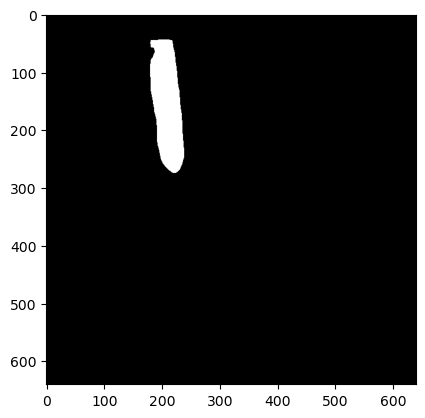

In [25]:
# prompt: show result[0].masks as image

import matplotlib.pyplot as plt

if result[0].masks is not None:
  mask = result[0].masks.data[0].cpu().numpy()
  plt.imshow(mask,cmap='gray')
  plt.show()


In [26]:
result[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0.,

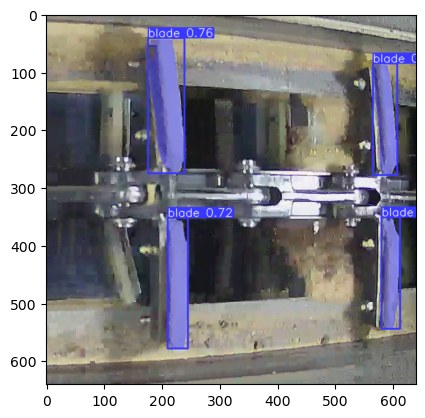

In [27]:
plt.imshow(im[:,:,[2,1,0]])

In [17]:
all_detected_blade

array([[          1,           0,      405.49,      314.21,      55.423,      498.55,     0.72737]])

## การกรองและวิเคราะห์ข้อมูล
กรองข้อมูลที่ได้จากการตรวจจับ แปลงเป็น DataFrame และเพิ่มคอลัมน์ 'label' เพื่อระบุตำแหน่งของวัตถุ (บน กลาง ล่าง)

แสดงผลการวิเคราะห์ เช่น กราฟการกระจายของวัตถุตามเฟรมและตำแหน่ง y, แสดงภาพตัวอย่างที่มีการตรวจจับ, และ box plot แสดงการกระจายของขนาดวัตถุตามตำแหน่ง

In [28]:
df = pd.DataFrame(data = all_detected_blade,
                  columns = ['id','frame','x','y','width','height','confident'])

In [29]:
filtered_df=df.sort_values('frame', ascending=True).drop_duplicates(['id'])
#filtered_df=df.sort_values('frame', ascending=False).drop_duplicates(['id'])

In [30]:
fig = px.scatter(filtered_df,x='frame',y='y',size='width',color='width',hover_name='id')
fig.show()

In [31]:
filtered_df['label']='center'
filtered_df.loc[filtered_df['y']>350,['label']]='top'
filtered_df.loc[filtered_df['y']<250,['label']]='bottom'

In [32]:
px.box(filtered_df[['x','y','width','height','label']], color="label")

In [33]:
px.box(filtered_df[['width','label']], color="label",points='all')

In [34]:
px.histogram(filtered_df[['width','label']], color="label")

## เก็บภาพที่คิดว่าน่าจะมีปัญหา

In [36]:
# !rm -r /content/problem
!mkdir problem

In [37]:
from logging import exception
import shutil

In [40]:
problem=filtered_df[filtered_df['label']=='center']
problem=problem[problem['width']>80]

for index, row in problem.iterrows():
    ff=int(row['frame'])
    try:
        shutil.copyfile(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\frames\im{:05d}.jpg'.format(ff), r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\problem\im{:05d}.jpg'.format(ff))
    except:
        pass

In [41]:
problem=filtered_df[filtered_df['label']=='top']
problem=problem[problem['width']>60]

for index, row in problem.iterrows():
    ff=int(row['frame'])
    try:
        shutil.copyfile(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\frames\im{:05d}.jpg'.format(ff), r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\problem\im{:05d}.jpg'.format(ff))
    except:
        pass

In [42]:
problem=filtered_df[filtered_df['label']=='bottom']
problem=problem[problem['width']>60]

for index, row in problem.iterrows():
    ff=int(row['frame'])
    try:
        shutil.copyfile(r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\frames\im{:05d}.jpg'.format(ff), r'D:\KKU_World\Learn\second_year\2_1\aiWorkshop\for_final_exam\problem\im{:05d}.jpg'.format(ff))
    except:
        pass

# Workshop 16 เพิ่มการทำนายตำแหน่งถัดไป

## ปรับปรุงการแสดงผล

In [ ]:
def draw_id(img,tracked_blade):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2
    img = cv2.putText(img, 'Frame:{:05d}'.format(int(tracked_blade[0,1])), (50,50), font,
                   fontScale, color, thickness, cv2.LINE_AA)
    for i in range(tracked_blade.shape[0]):
        posi=(int(tracked_blade[i,2]),int(tracked_blade[i,3]))
        img = cv2.putText(img, 'ID:{:02d}'.format(int(tracked_blade[i,0])), posi, font,
                   fontScale, color, thickness, cv2.LINE_AA)
    return img

## เพิ่มการทำนายตำแหน่ง

In [ ]:
def predict_next_position(tracked_blade,predict_x=50):
    # เพิ่มการทำนายตำแหน่งในเฟรมถัดไปโดยเพิ่ม
    tracked_blade[:,2] += predict_x
    return tracked_blade

In [ ]:
cap = cv2.VideoCapture('/content/empty4.mp4')

sample_rate=1

r=270
c=1100

frame_width = 640
frame_height = 640
fps=cap.get(cv2.CAP_PROP_FPS)
new_fps=int(fps/sample_rate)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')

out = cv2.VideoWriter('track_output_fps{:d}.mp4'.format(new_fps),fourcc, new_fps, (frame_width,frame_height))

start=time.time()
fno = 0
all_detected_blade=np.empty((0,7))
tracked_blade=np.empty((0,7))
id_blade=[]
blade_count=0

success = cap.grab()
while(success):
    if True or fno % sample_rate == 0:
        ret, frame = cap.retrieve()
        im=cv2.cvtColor(frame[r:r+640,c:c+640,:], cv2.COLOR_BGR2RGB)
        result=model.predict(im,classes=[0],verbose=False,conf=0.5)
        xywh=result[0].boxes.xywh.cpu().numpy()
        conf=result[0].boxes.conf.cpu().numpy()
        if len(conf)>=1:
            objs=np.c_[np.repeat(0, xywh.shape[0]),np.repeat(fno, xywh.shape[0]), xywh, conf ]
            objs=filter_objs(objs,x1=100,x2=500)
            if len(objs)>0:
                if len(tracked_blade)==0:
                    tracked_blade,blade_count=initial_blade(objs)
                else:
                    tracked_blade,blade_count=fill_id(objs,tracked_blade,blade_count,threshold=THRESHOLD)

                all_detected_blade=np.r_[ all_detected_blade, tracked_blade]

                im=draw_id(result[0].plot(),tracked_blade)
                tracked_blade=predict_next_position(tracked_blade)
                tracked_blade=filter_objs(tracked_blade)
                im=cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
                cv2.imwrite('frames/im{:05d}'.format(fno)+'.jpg',im)
                out.write(im)

        # print(fno)
    # break
    if fno>2000:
        break
    success = cap.grab()
    fno +=1
cap.release()
out.release()
tt=time.time()-start
print('(tt,fno)',(tt,fno),'(fps,fno/tt)',(fps,fno/tt))

(tt,fno) (71.47772693634033, 2001) (fps,fno/tt) (30.0, 27.994734664437992)


# การปรับปรุงการติดตามวัตถุ

## delete duplicate
การจัดการกับวัตถุที่ซ้ำซ้อน และ

In [ ]:
def clean_twin(blade):
    keep=[True for _ in range(blade.shape[0])]
    for i in range(blade.shape[0]-1):
        for j in range(i+1,blade.shape[0]):
            if euclidean_distance(blade[i,2:4],blade[j,2:4])<THRESHOLD:
                keep[j]=False
    return blade[keep,:]

## Object re-registration
ส่วนนี้เป็นการปรับปรุงกระบวนการติดตามวัตถุ ให้มีประสิทธิภาพมากขึ้น โดยรองรับกรณีที่การตรวจจับวัตถุล้มเหลว หรือไม่มีวัตถุใหม่ที่ตรงกับตำแหน่งที่ทำนายไว้ ผมจะอธิบายแนวคิดและโค้ดที่เกี่ยวข้องดังนี้:

แนวคิด:
เมื่อไม่สามารถตรวจจับวัตถุใหม่ที่ตรงกับตำแหน่งที่ทำนายไว้ แทนที่จะละทิ้งข้อมูลการติดตามนั้น เราจะรวมตำแหน่งที่ทำนายไว้เข้าไปในกระบวนการติดตาม ทำให้สามารถติดตามวัตถุได้ต่อเนื่อง แม้ในบางเฟรมจะไม่สามารถตรวจจับวัตถุได้

In [ ]:
def get_id(blade,tracked_blade,count,threshold): # return id and max count
    for i in range(tracked_blade.shape[0]):
        if euclidean_distance(blade[2:4],tracked_blade[i,2:4])<threshold:
            return tracked_blade[i,0],count,i
    nex_id=count+1
    return nex_id, nex_id, None


def fill_id(blades,tracked_blade,count,threshold=50):
    notpaired=[True for _ in range(tracked_blade.shape[0])]
    for i in range(blades.shape[0]):
        blades[i,0],count,ind=get_id(blades[i,:],tracked_blade,count,threshold)
        if ind is not None:
            notpaired[ind]=False
    tracked_blade=tracked_blade[notpaired,:]
    tracked_blade[:,1]=blades[0,1]
    blades=np.r_[blades,tracked_blade]
    return blades,count

# All Code

In [ ]:
model = YOLO("yolov8s-seg-blade.pt")  # load a pretrained model (recommended for training)
model.fuse()

YOLOv8s-seg summary (fused): 195 layers, 11,780,761 parameters, 0 gradients, 42.4 GFLOPs


In [ ]:
def initial_blade(blade):
    count=0
    for i in range(blade.shape[0]):
        count+=1
        blade[i,0]=count
    return blade,count

def euclidean_distance(p1,p2):
    dd=(p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
    return math.sqrt(dd)

def draw_id(img,tracked_blade):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2
    img = cv2.putText(img, 'Frame:{:05d}'.format(int(tracked_blade[0,1])), (50,50), font,
                   fontScale, color, thickness, cv2.LINE_AA)
    for i in range(tracked_blade.shape[0]):
        posi=(int(tracked_blade[i,2]),int(tracked_blade[i,3]))
        img = cv2.putText(img, 'ID:{:02d}'.format(int(tracked_blade[i,0])), posi, font,
                   fontScale, color, thickness, cv2.LINE_AA)
    return img

def predict_next_position(tracked_blade,predict_x=50):
    # เพิ่มการทำนายตำแหน่งในเฟรมถัดไปโดยเพิ่ม
    tracked_blade[:,2] += predict_x
    return tracked_blade

def get_id(blade,tracked_blade,count,threshold): # return id and max count
    for i in range(tracked_blade.shape[0]):
        if euclidean_distance(blade[2:4],tracked_blade[i,2:4])<threshold:
            return tracked_blade[i,0],count,i
    nex_id=count+1
    return nex_id, nex_id, None


def fill_id(blades,tracked_blade,count,threshold=50):
    notpaired=[True for _ in range(tracked_blade.shape[0])]
    for i in range(blades.shape[0]):
        blades[i,0],count,ind=get_id(blades[i,:],tracked_blade,count,threshold)
        if ind is not None:
            notpaired[ind]=False
    tracked_blade=tracked_blade[notpaired,:]
    tracked_blade[:,1]=blades[0,1]
    blades=np.r_[blades,tracked_blade]
    return blades,count

In [ ]:
THRESHOLD=150
PREDICT_X=50

cap = cv2.VideoCapture('/content/empty4.mp4')

sample_rate=1

PREDICT_X=PREDICT_X*sample_rate
THRESHOLD=THRESHOLD*sample_rate

r=270
c=1100

frame_width = 640
frame_height = 640
fps=cap.get(cv2.CAP_PROP_FPS)
new_fps=int(fps/sample_rate)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')

out = cv2.VideoWriter('track_output_final_fps{:d}.mp4'.format(new_fps),fourcc, new_fps, (frame_width,frame_height))

start=time.time()
fno = 0
all_detected_blade=np.empty((0,7))
tracked_blade=np.empty((0,7))
id_blade=[]
blade_count=0

success = cap.grab()
while(success):
    if True or fno % sample_rate == 0:
        ret, frame = cap.retrieve()
        im=cv2.cvtColor(frame[r:r+640,c:c+640,:], cv2.COLOR_BGR2RGB)
        result=model.predict(im,classes=[0],verbose=False,conf=0.5)
        xywh=result[0].boxes.xywh.cpu().numpy()
        conf=result[0].boxes.conf.cpu().numpy()
        if len(conf)>=1:
            objs=np.c_[np.repeat(0, xywh.shape[0]),np.repeat(fno, xywh.shape[0]), xywh, conf ]
            objs=filter_objs(objs,x1=100,x2=500)
            objs= clean_twin(objs)
            if len(objs)>0:
                if len(tracked_blade)==0:
                    tracked_blade,blade_count=initial_blade(objs)
                else:
                    tracked_blade,blade_count=fill_id(objs,tracked_blade,blade_count,threshold=THRESHOLD)

                all_detected_blade=np.r_[ all_detected_blade, tracked_blade]

                im=draw_id(result[0].plot(),tracked_blade)
                im=cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
                cv2.imwrite('frames/im{:05d}'.format(fno)+'.jpg',im)
                out.write(im)
                tracked_blade=predict_next_position(tracked_blade,predict_x=PREDICT_X)
                tracked_blade=filter_objs(tracked_blade)

        # print(fno)
    # break
    if fno>200:
        break
    success = cap.grab()
    fno +=1
cap.release()
out.release()
tt=time.time()-start
print('(tt,fno)',(tt,fno),'(fps,fno/tt)',(fps,fno/tt))

(tt,fno) (8.820712089538574, 201) (fps,fno/tt) (30.0, 22.787275897870806)
